## Import Libraries

In [2]:
from os import walk #returns a generator, that creates a tuple of values (current_path, directories in current_path, files in current_path)
from os.path import join

import numpy as np #numerical data handling as well as support fo multidimensional arrays and matrices
import pandas as pd #data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer #Generate Vocabulary
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

## Constants

In [3]:
#https://spamassassin.apache.org/old/publiccorpus/
spam_1 = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
spam_2 ='SpamData/01_Processing/spam_assassin_corpus/spam_2'

ham_1 = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
ham_2 ='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

### Generator Function

In [4]:
def email_generator(path):
    
    for root, dirnames, filenames in walk(path):#walk function generates filenames in a directory by walking the tree from top to the bot tom and it yields a tuple consisting the directory path, name and filename.
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream: #read all the line in the file
                if is_body:
                    lines.append(line)#takes the lines list and append each line from each text file
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [5]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names) #Creating a dataframe for the given emails for each document 

In [6]:
spam_emails = df_from_directory(spam_1, 1) #categorize spam_emails as 1
spam_emails = spam_emails.append(df_from_directory(spam_2, 1))
spam_emails.shape

(1898, 2)

In [7]:
ham_emails = df_from_directory(ham_1, 0) #categorize non-spam as 0
ham_emails = ham_emails.append(df_from_directory(ham_2, 0))
ham_emails.shape

(3902, 2)

In [8]:
data = pd.concat([ham_emails, spam_emails]) #creating a dataframe for both spam and non-spam emails
data.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [9]:
data.shape

(5800, 2)

## Data Cleaning

In [11]:
#check if any message are null
data['MESSAGE'].isnull().values.any()

False

In [12]:
#check for missing value or empty emails
(data.MESSAGE.str.len() == 0).sum()


4

### Locate and remove empty emails

In [13]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

In [14]:
data = data.drop(['cmds'])

In [19]:
data.shape

(5796, 2)

### Adding Document IDs

In [15]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [16]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace = True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,00001.7c53336b37003a9286aba55d2945844c
1,"Martin A posted:\n\nTassos Papadopoulos, the G...",0,00002.9c4069e25e1ef370c078db7ee85ff9ac
2,Man Threatens Explosion In Moscow \n\n\n\nThur...,0,00003.860e3c3cee1b42ead714c5c874fe25f7
3,Klez: The Virus That Won't Die\n\n \n\nAlready...,0,00004.864220c5b6930b209cc287c361c99af1
4,"> in adding cream to spaghetti carbonara, whi...",0,00005.bf27cdeaf0b8c4647ecd61b1d09da613


### Visualizing the data

In [17]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

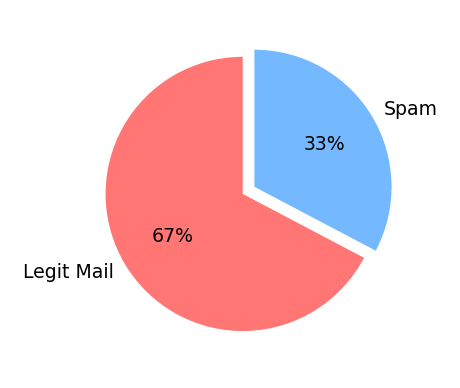

In [18]:
category_names = ['Legit Mail', 'Spam']
sizes = [amount_of_ham, amount_of_spam]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

## Preprocessing

### Function to tokenize, lowercase, removing stopwords and HTML tags

In [28]:
# def clean_msg(message, stemmer=PorterStemmer(), 
#                  stop_words=set(stopwords.words('english'))):
    
#     # Remove HTML tags
#     soup = BeautifulSoup(message, 'html.parser') #default parser
#     cleaned_text = soup.get_text()
    
#     # Converts to Lower Case and splits up the words
#     words = word_tokenize(cleaned_text.lower())
    
#     filtered_words = []
    
#     for word in words:
#         # Removes the stop words and punctuation
#         if word not in stop_words and word.isalpha():
#             filtered_words.append(stemmer.stem(word))
    
#     return filtered_words

In [19]:
data.sort_index(inplace=True)

In [20]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
5792,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
5793,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
5794,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
5795,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [22]:
vectorizer = CountVectorizer(stop_words='english')

In [23]:
all_features = vectorizer.fit_transform(data.MESSAGE) #creating a sparse matrix for the individual words or tokens created for the message column

In [24]:
all_features.shape

(5796, 102694)

In [25]:
vectorizer.vocabulary_

{'date': 32345,
 'wed': 95069,
 '21': 3894,
 'aug': 20848,
 '2002': 3508,
 '10': 1495,
 '54': 9185,
 '46': 8205,
 '0500': 603,
 'chris': 28094,
 'garrigues': 43942,
 'cwg': 31604,
 'dated': 32351,
 '1030377287': 1637,
 '06fa6d': 692,
 'deepeddy': 32907,
 'com': 29405,
 'message': 61680,
 'id': 49828,
 '1029945287': 1621,
 '4797': 8283,
 'tmda': 87922,
 'vircio': 92852,
 'reproduce': 77672,
 'error': 39109,
 'repeatable': 77582,
 'like': 58501,
 'time': 87625,
 'fail': 40568,
 'debug': 32763,
 'log': 59136,
 'pick': 71493,
 'happening': 46648,
 '18': 2693,
 '19': 2800,
 '03': 490,
 'pick_it': 71494,
 'exec': 39751,
 'inbox': 51485,
 'list': 58680,
 'lbrace': 57730,
 'subject': 84789,
 'ftp': 43157,
 'rbrace': 76455,
 '4852': 8316,
 'sequence': 81267,
 'mercury': 61635,
 '04': 552,
 'ftoc_pickmsgs': 43142,
 'hit': 47654,
 'marking': 60814,
 'hits': 47669,
 'tkerror': 87814,
 'syntax': 85694,
 'expression': 40003,
 'int': 52260,
 'note': 65874,
 'run': 79445,
 'command': 29468,
 'hand': 4

### Train-test split data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(all_features, data.CATEGORY, 
                                                   test_size=0.3, random_state = 42)

## Training the Naive Bayes

In [27]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [28]:
nr_correct = (y_test == classifier.predict(X_test)).sum()

In [29]:
print(f'{nr_correct} documents classfied correctly')

1638 documents classfied correctly


In [30]:
nr_incorrect = y_test.size - nr_correct

In [31]:
print(f'Number of documents incorrectly classified is {nr_incorrect}')

Number of documents incorrectly classified is 101


In [32]:
fraction_wrong = nr_incorrect / (nr_correct + nr_incorrect)
print(f'The (testing) accuracy of the model is {1-fraction_wrong:.2%}')
acc = classifier.score(X_test, y_test) * 100

The (testing) accuracy of the model is 94.19%


### Performance Matrix

In [33]:
recall = recall_score(y_test, classifier.predict(X_test))

In [34]:
prec = precision_score(y_test, classifier.predict(X_test))

In [35]:
f1 = f1_score(y_test, classifier.predict(X_test))

In [36]:
example = ['get stuff for free now!', 
          'need a mortgage? Reply to arrange a call with a specialist and get a quote', 
          'Could you please help me with the project for tomorrow?', 
          'Hello Jonathan, how about a game of golf tomorrow?', 
          'Ski jumping is a winter sport in which competitors aim to achieve the longest jump after descending from a specially designed ramp on their skis. Along with jump length, competitor\'s style and other factors affect the final score. Ski jumping was first contested in Norway in the late 19th century, and later spread through Europe and North America in the early 20th century. Along with cross-country skiing, it constitutes the traditional group of Nordic skiing disciplines.'
          ]

In [37]:
doc_term_matrix = vectorizer.transform(example)

In [38]:
classifier.predict(doc_term_matrix)

array([0, 1, 0, 0, 0], dtype=int64)

In [39]:
model_frame = {
               'Accuracy': [acc],
                'Precision':[prec],
              'Recall-Score':[recall],
              'F1-Score':[f1]}
model = pd.DataFrame(model_frame)
model

,Accuracy,Precision,Recall-Score,F1-Score
0,94.192064,0.978448,0.833028,0.899901


[[2697    9]
 [ 124 1227]]


Text(33.0, 0.5, 'True labels')

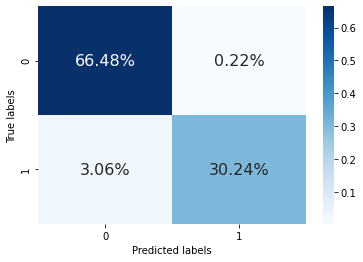

In [40]:

cm = confusion_matrix(y_train, classifier.predict(X_train))
print(cm)

ax = plt.subplot()
sns.heatmap(cm/np.sum(cm), annot= True, fmt='.2%',  cmap = 'Blues', annot_kws={"size": 16}) 

#labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
